In [1]:
import nltk
from functools import reduce
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter 
from matplotlib.colors import ListedColormap
import json
import folium
import re
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import hmean
from scipy.stats import norm
from sklearn import metrics, model_selection
%matplotlib inline
pth = r"C:\EPFL\2018-2019\nltk_data" #change location according to your nltk data path
nltk.data.path.append(pth)
sns.set()

C:\Anaconda\envs\ada\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


>>>> #                               <font color=red>An average citizen guide to fight Fake News</font>

##  <font color=blue>1. Introduction </font>

- The theme of this year is **"Data Science for social goods"**. We will try to follow this theme by helping people not believing everything they see by giving certain directional axes. 


- The vision we have for our datastory is a **guide for the average citizen** to make him more critical about information. Indeed with the exponential spread of data accessible to everyone, the challenge of getting rightly informed is getting harder and harder. Our aim is to make the distinction between the 'safe' and 'unreliable' topics and sources of information.


- We will try to show that some news are made to create doubt and decredibilize some people or organizations. We will try to give some directions by trying to **find recurrent patterns** of fake news and **how they are delivered** in order to warn people to always cross check their references to avoid being fooled half of the time.

##  <font color=blue>2. Exploration and Analysis </font>

### 2.1 Load and preprocess data

**Some helper functions**

In [2]:
stop_words = []

f = open('stopw.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words

def map_value(lab) :
    dict = {'true': 1, 'mostly-true' : 0.8, 'half-true' : 0.6, 'barely-true' : 0.4, 'pants-fire' : 0,  'false' : 0}
    return dict[lab]

def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

In [3]:
def load_and_process(path) :
    liar_df = pd.read_csv("LIAR/" + path, sep='\t', header=None)
    liar_df.columns = ['to_drop', 'label', 'text', 'subject', 'author', 'position', 'state', 'political_party', 'pants_on_fire'\
                  , 'false', 'barely true', 'half true', 'mostly true', 'source']
    liar_df = liar_df.dropna(subset=['subject']).reset_index(drop=True)
    
    liar_df['label'] = liar_df['label'].map(lambda l : map_value(l))
    
    liar_df['tokens'] = liar_df['text'].map(lambda d: tokenizer(d))
    
    liar_df['tokens'] = liar_df['tokens'].map(lambda d : ' '.join(d))
    
    liar_df = liar_df[(liar_df['label'] == 0) | (liar_df['label'] == 1)] #remove other news
    
    return liar_df

**We choose to focus only on Fake news and real news and remove other news labelled otherwise**

In [4]:
data = load_and_process('train.tsv')

In [5]:
def plot_na(d) :
    na_values = d.isna().mean(axis = 0)
    na_values.plot(kind='bar') #proportion of na values in each column
    plt.xlabel('columns')
    plt.ylabel('Proportion of missing values')
    plt.title('Distribution of missing values among columns from the dataset')
    plt.show()

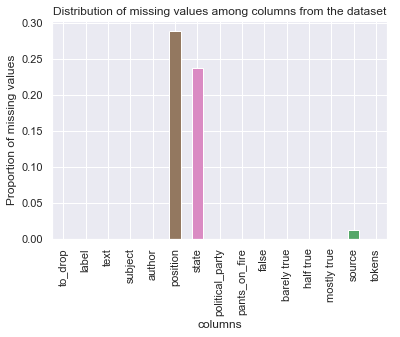

In [6]:
plot_na(data)

**We can see that most of the data are not missing, except for the position of the author of the news and the state where the news were emitted. A quite few source (magazine, social medial..) are also missing. However these informations may be rather relevant, particularly when checking if a news is fake or real, the source of the news is quite important. Let's have a look in which subset they are missing.**

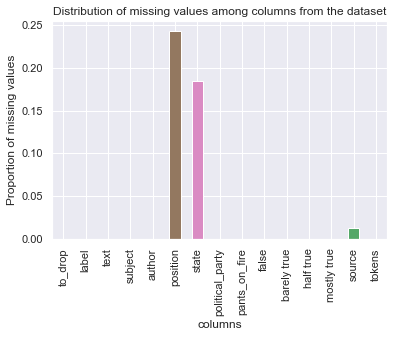

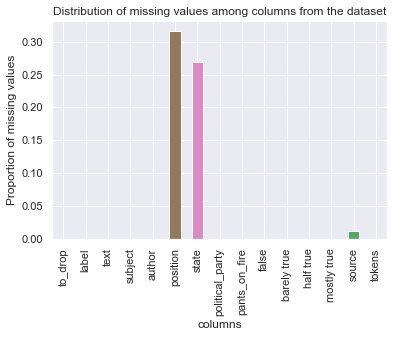

(None, None)

In [7]:
plot_na(data[data['label'] == 1]), plot_na(data[data['label'] == 0])

**It seems that there is not so much difference looking at the distribution of missing values between fake and real news subset. Hence we can't conclude anything here.**

### 2.2 Can we discriminate some news regarding their geographical origin ?

As observed above, geographical origin of some news are missing. Since they are missing in both subset, we cannot draw any particular insight about it. Since this lack of information is balanced between both data set, and not that important (20%), we decide to get rid of it for visualization purpose.

In [8]:
geog_data = data[~(data['state'].isna())]
geog_data = geog_data[['label', 'state']]
geog_data.groupby('state').count().shape

(68, 1)

It seems that we have extra states. We should have only 51 or less rows, since there only 51 (50 + DC) states in USA. When looking at the data, it seems that the spelling mistakes and the case of Washington state and DC is responsible for a large proportion of the additionnal 'states'. In order to clean it, we will group them together from the actual states to find the closest string matching the ones in the dataset.

In [9]:
correct_states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington, D.C.","Washington","West Virginia","Wisconsin","Wyoming"]

#we define a manual similarity measure
def similarity(vec1, vec2) :
    l1 = len(vec1)
    l2 = len(vec2)
    k = l1
    if(l2 < l1) :
        k = l2
    p = 0
    for i in range(k) :
        if(vec1[i] in vec2) :
            p += 1
    return p/l2

def find_closest(old_text, list_text) :
    if(old_text == 'District of Columbia') :
        return "Washington, D.C."
    cosines = []
    for i in range(len(list_text)) :
        v = list_text[i]
        cos = similarity(old_text, v)
        cosines.append(cos)
    index = np.argmax(cosines)
    return list_text[index]

In [10]:
states= geog_data.copy()
states.state = states.state.map(lambda x : find_closest(x, correct_states))
occurences = states.groupby('state').count().reset_index()
occurences.columns = ['state', 'occurences']

As a measure of "truthfulness" of the origin of a news, we will assign a score to each state, depending on some "credit history" based on the proportion of the different labels.

In [11]:
states_score = states.groupby('state').sum().reset_index()
states_score.columns = ['state', 'score']
states_score['occurences'] = occurences.occurences.values
states_score['score'] /= occurences['occurences'].values

In [12]:
states_score.describe()

,score,occurences
count,49.000000,49.000000
mean,0.374718,70.122449
std,0.217527,106.209822
min,0.000000,1.000000
25%,0.266667,5.000000
50%,0.400000,26.000000
75%,0.470588,79.000000
max,1.000000,438.000000


Some states don't have enough data in terms of number of news originating from them. Some of them occur only 3 times and have a score of 100% when others occur more than 200 times and have a score of 50% . In order to balance it, we will put a threshold, and get rid of them when the number of occurences is lower than 20.

In [13]:
for i in range(len(states_score.score)) :
    k = states_score.score[i]
    occ = states_score.occurences[i]
    states_score.score[i] = k if occ >= 20 else None

C:\Anaconda\envs\ada\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
states_score.sort_values('score', ascending=False).head()

,state,score,occurences
32,Ohio,0.581818,220
11,Illinois,0.541463,205
18,Maryland,0.538462,26
42,Vermont,0.518519,27
3,Arkansas,0.500000,28


Let's visualize the score on the USA map using Folium

In [15]:
state_geo_path = r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

In [16]:
states_score = states_score.dropna()

In [17]:
from branca.colormap import LinearColormap

In [18]:
map_dict = states_score.set_index('state')['score'].to_dict()
color_scale = LinearColormap(['r', 'b'], caption = 'Trust Score of USA states' , vmin = min(map_dict.values()), vmax = max(map_dict.values()))

In [19]:
def get_color(feature):
    value = map_dict.get(feature['properties']['name'])
    if value is None:
        return '#8c8c8c' # MISSING -> gray
    else:
        return color_scale(value)

m = folium.Map(location=[48, -102], zoom_start=3)

g = folium.GeoJson(
    data =  state_geo_path,
    style_function = lambda feature: {
        'fillColor': get_color(feature),
        'fillOpacity': 0.7,
        'color' : 'black',
        'weight' : 1,
    }    
)

m.add_child(g)

m.add_child(color_scale) #add legend

When observing the map, it seems that geographical origin of news is not that relevant in determining its validity. This can be explained by the virtualization of the human interactions by the word wide web as well as the explosion of the travelling power of the individuals. Indeed the creation of fake news can be done anywhere in the digital age.

### 2.3 Can we classify some source as less reliable than others ?

In [20]:
source_df = data[['label', 'source']]
print('We have {}% of nan values in sources'.format(source_df.isna().mean(axis=0)[1]))
print('Since we have so few nan values that we can just classify threm as unknown')
source_df = source_df.fillna('Unknown')
print('When grouping them by source, we get {} different values for sources'.format(source_df.groupby('source').agg('count').shape[0]))
print("For example, we have {} different rows that contains CNN as source".format(source_df[source_df['source'].str.contains('CNN')].shape[0]))
print("Out of these 237 rows containing CNN, {} are different, this shows us the amount of little textual variations in the source"\
      .format(source_df[source_df['source'].str.contains('CNN')].groupby('source').agg('count').shape[0]))

We have 0.011535048802129548% of nan values in sources
Since we have so few nan values that we can just classify threm as unknown
When grouping them by source, we get 2323 different values for sources
For example, we have 98 different rows that contains CNN as source
Out of these 237 rows containing CNN, 54 are different, this shows us the amount of little textual variations in the source


In [21]:
source_df['source'] = source_df['source'].map(lambda d: tokenizer(d))
source_df['source'] = source_df['source'].map(lambda d : ' '.join(d))

In [22]:
top = Counter(source_df.source.values)
top = sorted(top.items(), key=lambda k: k[1], reverse=True)

In [23]:
top = [x[0] for x in top[:30]]
print('By keeping only the 30 most frequent word in source, we work with {}% of our data.'\
    .format(source_df[source_df['source'].str.contains('|'.join(top))].shape[0]/source_df.shape[0]*100))

By keeping only the 30 most frequent word in source, we work with 62.089618456078085% of our data.


In [24]:
#we work now with the reduced df (the 'source' column of each row contains at least 1 word from our top list)
reduced_source = source_df[source_df['source'].str.contains('|'.join(top))]

#create an empty table that will contain the 30 most frequent words as columns, and the 2 categorical label as rows. 
source_table = pd.DataFrame(np.zeros((2, len(top))), columns=top)
labels = [0.0, 1.0] #Fake then Real news
#for each row in our df, add +1 in the new created df for each word appearing in the source column & in our top list
for index, row in reduced_source.iterrows():
    words = [s for s in top if s in row['source']]
    r = labels.index(row['label'])
    for word in words:
        #row index with respect to the labels
        source_table.loc[r,word] += 1

In [25]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        total = df[feature_name].sum()
        result[feature_name] = (df[feature_name] / total)
    return result

In [26]:
n_reduced_df = normalize(source_table).T
n_reduced_df.columns  = ['false', 'true']

In [27]:
n_reduced_df.head(10)

,false,true
press release,0.484076,0.515924
news release,0.611111,0.388889
speech,0.574514,0.425486
interview,0.665385,0.334615
tweet,0.623762,0.376238
tv ad,0.681818,0.318182
radio interview,0.710843,0.289157
debate,0.628931,0.371069
news conference,0.500000,0.500000
unknown,0.615385,0.384615


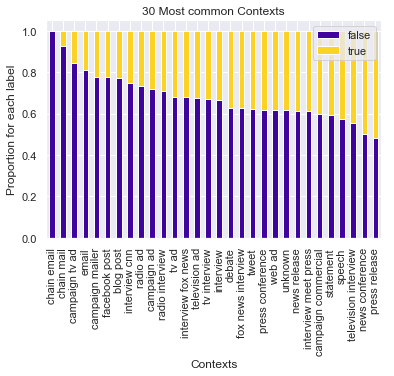

In [28]:
n_reduced_df\
.sort_values(by='false', ascending=False)\
.plot(kind='bar', stacked=True, colormap = ListedColormap(sns.color_palette('plasma',10)))
plt.title('30 Most common Contexts')
plt.ylabel('Proportion for each label')
plt.xlabel('Contexts')
plt.savefig('common_context.png')
plt.show()

Looking at the plot we can clearly distinguish two trends between Real news and fake ones.**
- We can see that Fake news mostly originate from online publications, such as mail, social media or as advertisements; which make them less reliable sources.
- On the contrary, Real news are released from official and widely publicly spread channels like television interview, press or news release, which tend to make them less unreliable sources.

Similarly, we have chosen earlier not to get rid of missing values but to mark then as "unknown". When looking at the plots, it seems that unknown sources are more present in fake news than in real ones (61.5 % against 31.5%) just like most contexts.

### 2.4 Are there suspicious topics where extra caution is advised ?

In [29]:
whole_topics = data[['label', 'subject']]
neg_topics = whole_topics[whole_topics['label'] == 0]
pos_topics = whole_topics[whole_topics['label'] == 1]

In [30]:
#function define to generate wordcloud of topics according to the given subset
def plot_subset(d, title, n) :
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    vz = vectorizer.fit_transform(list(d.subject))
    tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
    tfidf.columns = ['tfidf']
    text = tfidf.sort_values(by=['tfidf'], ascending=False).head(n).index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

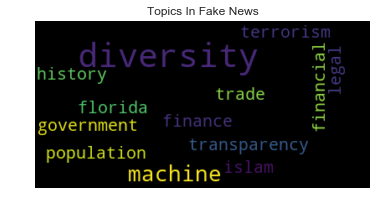

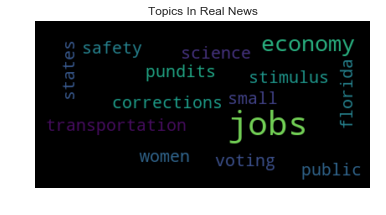

In [31]:
plot_subset(neg_topics, 'Topics In Fake News', 10)
plot_subset(pos_topics, 'Topics In Real News', 10)

We plotted the 10 most meaningful Topics using TF-IDF. It is a statistical metric used to measure how important a term is to a document in a dataset. One of the main characteristics of IDF is it weights down the term frequency while
scaling up the rare ones.Hence, it allows us not to target topics which are widely spread independantly from being in fake or real news, but to extract meaningful topics which are relevant depending on the subset of study.

When we look at the WordCloud produced above, we notice the following :
- Most importants topics in Real news refer to topics delivered from "serious" press release. Science or economy newspapers, statements and figures on Jobs, transportation and Safety concerns, in which the experts ("pundits" appearing in the Wordcloud) establishing the facts mentioned are quoted

- On the other hand, it seems that when observing the WordCloud from Fake news, most of the information relates to conspiracy theory, with buzzwords such as "terrorism", "islam", "government" . Furthermore, "Diversity" appears to be the most relevant word. As we know, immigration and asylum are becoming increasingly controversial issues. It seems, that hype and fear are used to promote differences and intolerance. Hence, it's not surprising at all to find "Diversity" as the most important topic in Fake news.

##  <font color=blue>3. Classification Process </font>

We present in the following an n-gram features based approach to detect fake news, which consists of using text analysis based on n-gram features and machine learning classification techniques. We will conduct an experiment to compare different models


**1. Choice of the metric for model selection :**
- In Fake news detection, a false positive means that news that are not fake (reals, actual negative) have been identified as fake (predicted fake). The reader/audience might lose important news if the precision is not high for the fake news detection model.

    
- Similarly, if fake news (Actual Positive) are predicted as real ones (Predicted Negative), the consequence can be very bad depending on the situation, let's say during election polls for example, when the candidate might lose voters/points.

Consequently, **F1-Score** might be a better measure to use since we need to seek a balance between Precision and Recall

**2. Interpretabiliy of the chosen model :**

A common quote on model interpretability is that with an increase in model complexity, model interpretability goes down at least as fast.

source : https://towardsdatascience.com/interpretability-in-machine-learning-70c30694a05f

We will use **Feature importance** to interpret our models. 

* In generalized linear models (logistic regression for example), we know that the weights that are obtained after training are a direct proxy of feature importance and they provide very concrete interpretation of the model internals. If the most important words/topics do not correspond to our intuition (e.g. names or stopwords, base on the analysis we performed in Part 2), it probably means that the model is fitting to noise in the dataset and it won’t perform well on new data.

* Tree based models (Random Forest for example) also allow to obtain information on the feature importance. It even allows us to plot the tree as a path to follow, which would be great for us, as we want to construct a guide for the average citizen.

* Although kernel methods (SVM for example) are able to capture non-linear relations between variables by projecting the features into kernel space, they just looking at the weights as feature importance does not tell us much about their interaction.

* Deep learning models are known for their un-interpretability due to the number of parameters and the complex approach to extracting and combining features, even if they are known to obtain better performance than others on a lot of tasks.

### 3.1 Model Selection

Based on the discussion above, we decide to choose **Random Forest** and **Logistic Regression** for their interpretability purpose. We will train our models, tune them and select the one which achieve the highest **F1-Score**.

In [32]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score,\
                            accuracy_score, precision_score, confusion_matrix, f1_score

from IPython.display import Image
from sklearn.tree import export_graphviz
import os

In [33]:
train_data = load_and_process('train.tsv')
validation_data = load_and_process('valid.tsv')
test_data = load_and_process('test.tsv')

In [34]:
#concatenate valid and test set into a single test set
new_test_data =  pd.concat([test_data, validation_data])

In [35]:
y_train = train_data.label
y_test = new_test_data.label
X_train = train_data.tokens
X_test = new_test_data.tokens

We choose to set the positive as fake news and negative ones as real news.

In [36]:
y_train = np.where(y_train < 0.5, 1, 0)
y_test = np.where(y_test < 0.5, 1, 0)

### 3.2 Random Forest

In [37]:
#choose hyperparameters for randomized Search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 20, num = 4)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

In [38]:
#fill the random forest grid parameters
rf_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [39]:
#rf with best params
rf = RandomForestClassifier(n_estimators = 800, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt',\
                             max_depth = 10, bootstrap = False)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_grid,\
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='f1')
rf_tfidf = TfidfVectorizer(ngram_range=(1,2))

#We use the pipeline to first transform the data using TF-IDF transformer and then fit the classifier
rf_clf_pipeline = Pipeline([('tfidf', rf_tfidf),('clf', rf_random)])

In [40]:
rf_clf_pipeline.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,..._jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=2))])

In [41]:
y_predict = rf_clf_pipeline.predict_proba(X_test)
y_tres = np.where(y_predict[:,1]< 0.6, 0, 1)

In [42]:
confusion_matrix(y_test, y_tres)

array([[129, 248],
       [114, 606]], dtype=int64)

We used the confusion matrix to choose the best suitable threshold.

In [43]:
def plot_prec_recall_vs_tresh(y, pred):
    
    precisions, recalls, thresholds = precision_recall_curve(y, pred)
    
    f1 = 2*(precisions*recalls)/(precisions+recalls)
    plt.plot(thresholds, f1[:-1], 'r--', label='f1 score')
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    
    accuracy = []
    for t in thresholds:
        accuracy.append(np.mean(y == np.where(pred<t,0,1)))
    plt.plot(thresholds, accuracy, 'y--', label = 'accuracy') 
    
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.ylim([0,1])

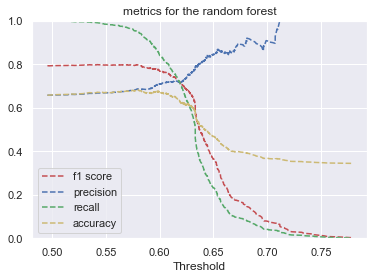

In [44]:
plot_prec_recall_vs_tresh(y_test, y_predict[:,1])
plt.title('metrics for the random forest')
plt.show()

We choose the results that gave us the best balance between precision and recall.

### 3.3 Logistic Regression

In [45]:
logistic_grid = {'max_iter' : [100,200,300,400],
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                }

In [46]:
log_reg = LogisticRegression()
log_reg_random = RandomizedSearchCV(estimator = log_reg, param_distributions = logistic_grid,\
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='f1')
lr_tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=(1000))
#we can choose to run the pipelin with either the random forest classifier with fixed param or the randomized search
log_reg_clf_pipeline = Pipeline([('tfidf', lr_tfidf),('clf', log_reg_random)])

In [47]:
log_reg_clf_pipeline.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,..._jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=2))])

In [48]:
y_pred = log_reg_clf_pipeline.predict_proba(X_test)
y_tres = np.where(y_pred[:,1]< 0.62, 0, 1)

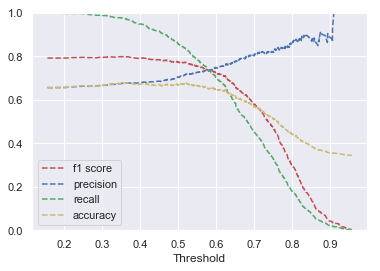

In [49]:
plot_prec_recall_vs_tresh(y_test, y_pred[:,1])
plt.show()

Similarly as above, we choose a balance between precision and recall.

In [50]:
confusion_matrix(y_test, y_tres)

array([[221, 156],
       [239, 481]], dtype=int64)

In [51]:
class_labels = log_reg_random.classes_
bs = log_reg_random.best_estimator_
feature_names = lr_tfidf.get_feature_names()
topn_class1 = sorted(zip(bs.coef_[0], feature_names))[:10]
topn_class2 = sorted(zip(bs.coef_[0], feature_names))[-10:]

In [52]:
print('Top 10 meaningful words in real news')
true_news = []
false_news = []
for coef, feat in topn_class1:
    print(class_labels[0], coef, feat)
    true_news.append((feat, coef))    
print('----------------')
print('Top 10 meaningful words in fake news')
print()
for coef, feat in reversed(topn_class2):
    print(class_labels[1], coef, feat)
    false_news.append((feat, coef))
    
true_news = pd.DataFrame(true_news, columns=['feature', 'weight'])
false_news = pd.DataFrame(false_news, columns=['feature', 'weight'])

Top 10 meaningful words in real news
0 -2.0233540187595587 georgia
0 -1.7014550589834043 months
0 -1.576920474552781 child
0 -1.5396147775757456 day
0 -1.4675543946586087 half
0 -1.4537218421022007 top
0 -1.415188746549047 terms
0 -1.4104441707438224 three
0 -1.408315695796446 called
0 -1.3753382760504467 mccain
----------------
Top 10 meaningful words in fake news

1 2.1380062470774837 obamacare
1 1.6787822062305962 wisconsin
1 1.6328420352465072 medicare
1 1.4726716724441553 making
1 1.3318415144898004 muslim
1 1.3236798594849488 care law
1 1.295062727454336 raise
1 1.2231557175712042 illegal
1 1.2028954540889283 work
1 1.2025828381907129 obamas


### 3.4 Visualization

In [53]:
estimator = rf_random.best_estimator_.estimators_[5]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(rf_tfidf.vocabulary_.keys()),
                class_names = ['fake', 'true'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)